# Stock Market Prediction

# I. Packages

In [59]:
# importing packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import utils as ut
from importlib import reload
reload(ut)

<module 'utils' from 'D:\\Bea\\Projects\\github\\stock_price_prediction\\utils.py'>

In [27]:
# set pandas options 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 999)

In [28]:
# setting the seed for reproducitble results
from numpy.random import seed
seed(5)

# II. Data Exploration
## II.1. Selecting a company ticker
Find the ticker symbol for the comany which closing stock price we want to predict. <br>

**dataset**: US Stocks & ETFs - Tickers, Company Info, Logos <br>
- In this dataset we can search for companies, whose stock price we want to predict. For example, I am going to select a company based on its industry.

In [29]:
# reading in the dataset
df_us_stocks = pd.read_csv('data/companies.csv')

# we won't need this kind of data for finding the ticker we need
df_us_stocks = df_us_stocks.drop(['website', 'logo',  'ceo'], axis = 1)

df_us_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6368 entries, 0 to 6367
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ticker        6368 non-null   object 
 1   company name  6368 non-null   object 
 2   short name    6368 non-null   object 
 3   industry      5418 non-null   object 
 4   description   6207 non-null   object 
 5   exchange      6368 non-null   object 
 6   market cap    6367 non-null   float64
 7   sector        5418 non-null   object 
 8   tag 1         5424 non-null   object 
 9   tag 2         5424 non-null   object 
 10  tag 3         3295 non-null   object 
dtypes: float64(1), object(10)
memory usage: 547.4+ KB


In [30]:
df_us_stocks.sample(5)

,ticker,company name,short name,industry,description,exchange,market cap,sector,tag 1,tag 2,tag 3
1217,COLB,Columbia Banking System Inc.,Columbia Banking System,Banks,"Columbia Banking System Inc is active in the financial services domain. It is the holding company for Columbia State Bank, which provides products for the small and medium sized business. It also provides services to professionals and individuals.",Nasdaq Global Select,2.729585e+09,Financial Services,Financial Services,Banks - Regional - US,Banks
5541,TFI,SPDR Nuveen Bloomberg Barclays Municipal Bond,SPDR Nuveen Bloomberg Barclays Municipal Bond,NaN,"The investment seeks investment results that correspond generally to the price and yield performance of the Bloomberg Barclays Municipal Managed Money 1-25 Years Index.\n The fund invests substantially all, but at least 80%, of its total assets in the securities comprising the index or in securities that the Sub-Adviser determines have economic characteristics that are substantially identical to the economic characteristics of the securities that comprise the index. The index is designed to track the U.S. fully tax-exempt bond market. It is non-diversified.",NYSE Arca,2.839438e+09,NaN,NaN,NaN,NaN
1474,DCPH,Deciphera Pharmaceuticals Inc.,Deciphera Pharmaceuticals,Biotechnology,Deciphera Pharmaceuticals Inc is a clinical-stage biopharmaceutical company developing new drugs to improve the lives of cancer patients.,Nasdaq Global Select,1.045098e+09,Healthcare,Healthcare,Biotechnology,NaN
5211,SMN,ProShares UltraShort Basic Materials,ProShares UltraShort Basic Materials,NaN,"The investment seeks daily investment results, before fees and expenses, that correspond to two times the inverse (-2x) of the daily performance of the Dow Jones U.S. Basic MaterialsSM Index.\n The fund invests in financial instruments that ProShare Advisors believes, in combination, should produce daily returns consistent with the fund's investment objective. The index seeks to measure the performance of certain companies in the basic materials sector of the U.S. equity market. The fund is non-diversified.",NYSE Arca,6.557795e+06,NaN,NaN,NaN,NaN
2942,INFN,Infinera Corporation,Infinera,Communication Equipment,"Infinera Corp is an optical transport networking equipment provider. The company serves telecommunications service providers, Internet content providers, cable providers, research and education institutions, and government entities.",Nasdaq Global Select,8.626846e+08,Technology,Technology,Communication Equipment,NaN


In [31]:
# list all industries
df_us_stocks['industry'].unique()

array(['Medical Diagnostics & Research', 'Metals & Mining',
       'Asset Management', 'Health Care Providers', nan, 'Airlines',
       'Insurance - Life', 'Consulting & Outsourcing', 'Semiconductors',
       'Building Materials', 'Retail - Apparel & Specialty',
       'Computer Hardware', 'REITs', 'Transportation & Logistics',
       'Aerospace & Defense', 'Industrial Products', 'Drug Manufacturers',
       'Medical Distribution', 'Banks', 'Biotechnology',
       'Beverages - Alcoholic', 'Autos', 'Communication Equipment',
       'Business Services', 'Medical Devices', 'Brokers & Exchanges',
       'Engineering & Construction', 'Insurance', 'Application Software',
       'Consumer Packaged Goods', 'Credit Services', 'Waste Management',
       'Oil & Gas - Integrated', 'Utilities - Regulated',
       'Insurance - Property & Casualty', 'Farm & Construction Machinery',
       'Agriculture', 'Insurance - Specialty', 'Travel & Leisure',
       'Publishing', 'Homebuilding & Construction',
 

In [32]:
# select TOP 5 companies belonging to 'Education' industry based on their market cap
df_us_stocks[df_us_stocks['industry'] == 'Education'].sort_values(by='market cap', ascending=False).head(5)

,ticker,company name,short name,industry,description,exchange,market cap,sector,tag 1,tag 2,tag 3
5468,TAL,TAL Education Group American Depositary Shares,TAL Education American Depositary Shares,Education,"TAL Education Group is engaged in providing after-school tutoring programs for primary and secondary school students in China. It delivers its tutoring services through small classes, personalized premium services, and online course offerings.",New York Stock Exchange,1.799256e+10,Consumer Defensive,Consumer Defensive,Education & Training Services,Education
1723,EDU,New Oriental Education & Technology Group Inc. Sponsored ADR representing 1 (Cayman Islands),New Oriental Education & Technology Sponsored representing 1 (Cayman Islands),Education,"New Oriental Education & Technology Group Inc provides private educational services in China based on the number of program offerings, total student enrollments, and geographic presence.",New York Stock Exchange,1.215739e+10,Consumer Defensive,Consumer Defensive,Education & Training Services,Education
3429,LOPE,Grand Canyon Education Inc.,Grand Canyon Education,Education,"Grand Canyon Education Inc is an American for-profit educational company that operates a private university in Phoenix, Arizona, as well as online educational programs.",Nasdaq Global Select,4.493977e+09,Consumer Defensive,Consumer Defensive,Education & Training Services,Education
1052,CHGG,Chegg Inc.,Chegg,Education,Chegg Inc is a student-first connected learning platform empowering students to take control of their education to save time and money. It offers its products and services under Chegg services and required materials categories.,New York Stock Exchange,4.107588e+09,Consumer Defensive,Consumer Defensive,Education & Training Services,Education
3318,LAUR,Laureate Education Inc.,Laureate Education,Education,Laureate Education Inc is an international community of universities. The company provides higher education programs and services to students through an international network of licensed universities and higher education institutions.,Nasdaq Global Select,3.571212e+09,Consumer Defensive,Consumer Defensive,Education & Training Services,Education


In [33]:
# selecting a company
selected_company_ticker = 'TAL'
company_name = df_us_stocks[df_us_stocks['ticker'] == selected_company_ticker].iloc[0]['short name']

## II. 2. Explore the Stock Market Dataset
**dataset:** Huge Stock Market Dataset<br>

Don't forget that there are some days where we have no data - **stock market was closed** on these days.

In [34]:
# Read in the data based on some criteria
zip_file_path = 'data/huge_stock_market_data.zip'
# company ticker format should be: companyticker.us.txt
company_ticker = 'tal.us.txt'
date_interval = ['2014-01-01', '2016-12-31']

df_stock_market = ut.read_huge_market_stock_data(zip_file_path, company_ticker, date_interval)
df_stock_market.sample(5)

File is already unzipped


,Date,Open,High,Low,Close,Volume,OpenInt
1552,2016-12-23,11.3200,11.5300,11.1830,11.4070,1146954,0
1237,2015-09-25,5.0917,5.1580,5.0020,5.0418,2355240,0
1541,2016-12-08,11.6240,12.0510,11.6130,11.9840,4125672,0
1311,2016-01-12,7.0090,7.3095,6.9227,7.2265,3228948,0
1130,2015-04-24,6.1425,6.1425,6.0147,6.0163,1384830,0


In [35]:
df_stock_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 801 to 1556
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     756 non-null    datetime64[ns]
 1   Open     756 non-null    float64       
 2   High     756 non-null    float64       
 3   Low      756 non-null    float64       
 4   Close    756 non-null    float64       
 5   Volume   756 non-null    int64         
 6   OpenInt  756 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 47.2 KB


### II.2.1. Closing Price History

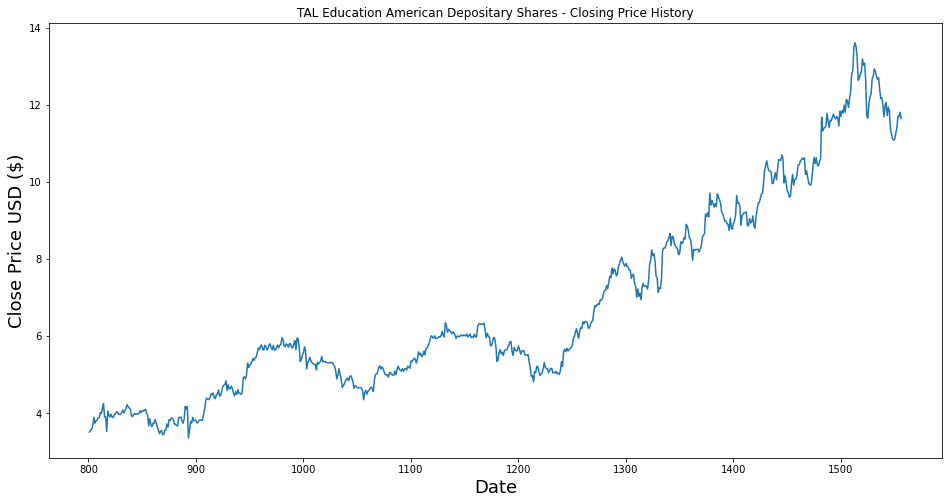

In [36]:
ut.plot_closing_price_history(df_stock_market['Close'], company_name)

### II.2.2. Exponential Moving Average (EMA)

In [37]:
# calculate  EMA for the last 60 days
df_stock_market['EMA_60'] = df_stock_market.iloc[:,3].ewm(span=60,adjust=False).mean()

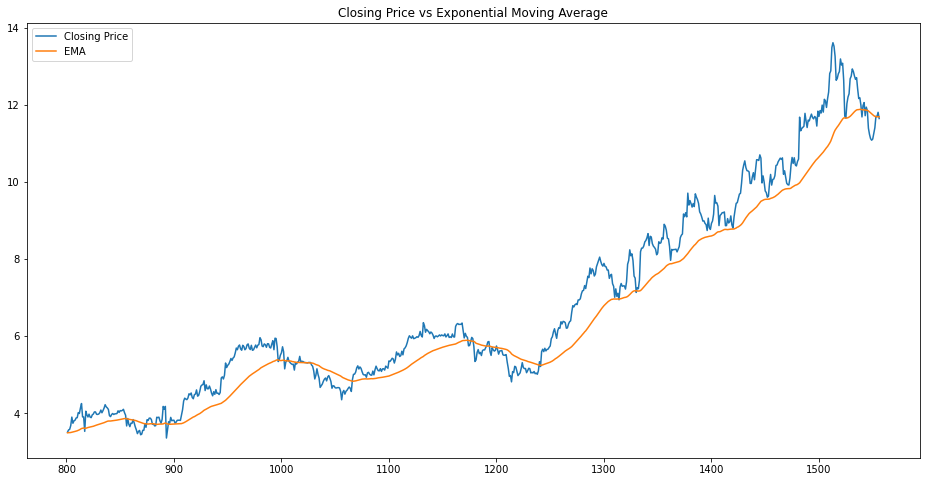

In [38]:
# plot closing price and moving average
ut.plot_closing_price_and_EMA(df_stock_market['Close'], df_stock_market['EMA_60'])

# III. Preparing data for LSTM

**1. Converting the data into array**

In [39]:
# filter only the 'Close' column
dataset = df_stock_market.filter(['Close'])

# and convert it to a numpy array
data = dataset.values

**2. Scaling the data.**

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(data)

**3. creating train & test data**

The train and test sets are going to contain moving values. 

**training set**: the past 60 day closing price values<br>
**test_set**: closing price on the 61st day

In [41]:
# we need to store the training data lenght into a separate variable, as we will need it for plotting the results later
training_data_len, x_train, y_train, x_test, y_test = ut.create_train_test_split(.7, 60, data, scaled_data)

**4. preparing data sets for LSTM**

LSTM is expecting a 3D dataset in the following format: [number of samples, number of time steps, and number of features]

In [42]:
# creating 3D arrays from input values
x_train = ut.create_3d_arrays(x_train)
x_test = ut.create_3d_arrays(x_test)


# IV. Modelling
Create the predicitve model using LSTM.

In [43]:
# build the LSTM  model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [44]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# train the model
model.fit(x_train, y_train, batch_size=10, epochs=5)

Epoch 1/5
470/470 [==============================] - 5s 11ms/step - loss: 0.0045

# V. Prediction

In [46]:
# get the model's predicted stock prices
predictions = model.predict(x_test)

# undo the scaling, so we can see the real prices, not the normalized ones
predictions = scaler.inverse_transform(predictions)

In [47]:
# Calculate RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print('RMSE: ', rmse)

RMSE:  0.5882701028942492


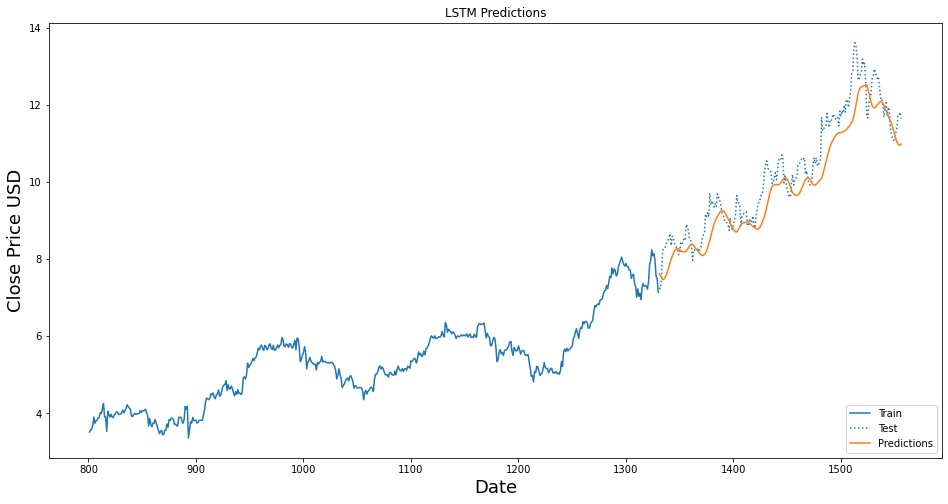

In [60]:
# see real and predicted values
ut.plot_result(dataset, training_data_len, predictions)